8-9 June 2015, P.M.

#Time Series Classification

The aim of this paper is to explore different representations and similarity measures for time series data.

The first step is to calculate the similarity between a test time series and the training test series. I use dynamic time warping (DTW) which calculates a distance between two time series; the smaller the distance, the more similar are the two time series. It is an *elastic similarity measure*, *i.e.* it recognises patterns between signals varying in time and speed. For example, two signals from people walking at different speeds will both be recognised as walking.

Calculating the DTW distances between the test sample and all training samples effectively moves the test sample to the origin of a distance space with the axes representing distance in x, distance in y, and distance in z.

$$
{\rm feature~matrix:~~~} {\bf F}~=~\left[
\begin{matrix}
X_{1} & Y_{1} & Z_{1} & P_{1}\\
X_{2} & Y_{2} & Z_{2}& P_{2}\\
\vdots & \vdots & \vdots & \vdots\\ 
X_{M} & Y_{M} & Z_{M} & P_{M}\\
\end{matrix}
\right]
$$

$$
{\rm label~vector:~~~} {\bf A}~=~ [a_1, a_2, \cdots a_M]
$$

where each $X_{M}$ (and similarly $Y_{M}$,$Z_{M}$,$P_{M}$):

$$
{\bf X_{M}}~=~\left[
\begin{matrix}
x_{1}\\
x_{2}\\
\vdots\\ 
x_{N}\\
\end{matrix}
\right]
$$

Applying DTW to ${\bf F}$ against a test event $[X_{test},Y_{test},Z_{test},P_{test}]$ yields ${\bf D}$:

$$
{\rm distance~matrix:~~~} {\bf D}~=~\left[
\begin{matrix}
d_{x_1} & d_{y_1} & d_{z_1} & d_{p_1}\\
d_{x_2} & d_{y_2} & d_{z_2} & d_{p_2}\\
\vdots & \vdots & \vdots & \vdots \\ 
d_{x_M} & d_{y_M} & d_{z_M} & d_{p_M}\\
\end{matrix}
\right]
$$

$$
{\rm label~vector:~~~} {\bf A}~=~ [a_1, a_2, \cdots a_M]
$$

The second step is use a classification algorithm to assign the test time series to a class of the training test series. Here, I use a nearest neighbour clustering algorithm to classify the test signal (KNN, with K=1).
 
See [Ding H. *et al.*](http://dl.acm.org/citation.cfm?id=1454226) for a comprehensive review of time series representation and similarity measures.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import mlpy as ml

###Load data
X = np.load('X.npy')[0:47,:,:]
y = np.load('A.npy')[0:47]

test = np.load('X.npy')[48,:,:]

###Calculate distance matrix against test sample
dist_X = np.zeros((X.shape[0],X.shape[1]),dtype=float)

start = time.time()
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        dist_X[i,j] = ml.dtw_std(X[i,j,:],test[j,:])

###Calculate distance for test sample against itself (should be 0)
dist_test = np.zeros((1,3), dtype=float)

#print test.shape
for i in range(test.shape[0]):
    dist_test[:,i] = ml.dtw_std(test[:,i],test[:,i])

model = ml.KNN(1)
model.learn(dist_X,y)

print model.pred(dist_test)

end = time.time()
print end-start
print dist_test

[4]
0.0337278842926
[[ 0.  0.  0.]]


##Plotting the calculated *distance space*

<matplotlib.colorbar.Colorbar instance at 0x1162e7c68>

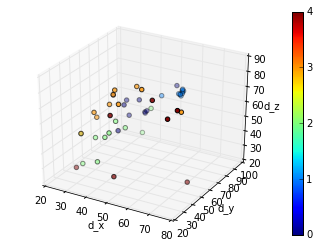

In [100]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.axes(projection='3d')
ax.scatter(dist_X[:,0], dist_X[:,1], dist_X[:,2], c=y)
#ax.view_init(40, -60)
ax.set_xlabel('d_x')
ax.set_ylabel('d_y')
ax.set_zlabel('d_z')

import matplotlib.cm as cm

m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(y)
plt.colorbar(m,ticks=[0, 1, 2, 3, 4])


```
fall = 4
lie down = 3
sit down = 2
stand = 1
walk = 0
```

#Assessing the strategy with a confusion matrix

The data set is small and therefore the classification is not very robust. Here, the dataset is split into two halves (25 and 25, each 5 from each category).

The algorithm is slightly involved, as a different distance matrix is calculated for each test time series and then used to train the KNN algorithm. This makes validation of the approach computationally more expensive. However, it will not be a problem for later implementation, as only one incoming signal will be analysed at a time.

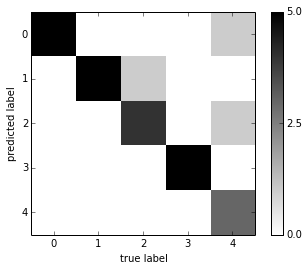

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time
import mlpy as ml

###Load data
X = np.load('X.npy')[1:50:2,:,:]
y = np.load('A.npy')[1:50:2]

X_test = np.load('X.npy')[0:50:2,:,:]
y_test = np.load('A.npy')[0:50:2]

###Calculate distance matrix against test sample
dist_X = np.zeros((X_test.shape[0],X.shape[0],X.shape[1]),dtype=float)

# k = test sample 
# i = row of training data
# j = feature or dimension (x,y,z)

for k in range(X_test.shape[0]):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            dist_X[k,i,j] = ml.dtw_std(X[i,j,:],X_test[k,j,:])

###Fitting and predicting
y_pred = np.zeros(X_test.shape[0], dtype=float)

model = ml.KNN(1)

for k in range(X_test.shape[0]): 
    model.learn(dist_X[k,:,:],y)
    y_pred[k] = model.pred([0.,0.,0.])

###Assess prediction accuracy
from sklearn import metrics
import matplotlib.cm as cm

plt.imshow(metrics.confusion_matrix(y_pred, y_test), interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar(ticks=[0,2.5,5])
plt.xlabel("true label")
plt.ylabel("predicted label");

**Conclusion:** This strategy is surprisingly accurate for such a small dataset.